# Interval Analysis Graphing Tool
## Intermountain Industrial Assessment Center (IIAC)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
from datetime import datetime as dt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Creating the dataframes

In [2]:
df = pd.read_csv('IPG_load_profile.csv')

time_title = 'Datetime'
power_title = 'kW'

df.dropna(subset = [time_title, power_title], inplace = True) #drops any NaN values in the dataset

df['Timestamp'] = pd.to_datetime(df[time_title]) #converting the time column into datetime

df.sort_values(['Timestamp'], inplace = True)
df.reset_index(inplace = True)

df = df[['Timestamp', power_title]] #recreating the dataframe with only the datetime and kW columns

which_months = df['Timestamp'].dt.month.unique() #This will find out which months are present
number_of_months = len(which_months) #How many different months there are

if type(df[power_title][0]) == str:               #if the kW has a unit, this turn it into a float value
    df[power_title] = df[power_title].str.extract('(\d+)').astype(float)

print(f'{number_of_months} months')
print(which_months)


11 months
[ 1  2  3  4  5  6  7  8  9 10 11]


In [3]:
# This section creates the dp dataframe used for the graphs.

time_interval = (df['Timestamp'][1] - df['Timestamp'][0]).total_seconds()/60 # difference between timestamps in minutes
intvls_a_week = int(24*7*(60/time_interval)) # how many time intervals there are in one week. Used for creating the dp dataframe

data = []

for i in which_months:
    md = df[df['Timestamp'].dt.month == i]
    mdt = md['Timestamp']
    
    for t in np.arange(0, intvls_a_week):
        time = mdt.iloc[t].time()    
        month = mdt.iloc[t].month
        dyofwk = mdt.iloc[t].weekday() + 1
        kW = np.mean(md[power_title].iloc[t::intvls_a_week])

        data.append([time, month, dyofwk, kW])
        
dp = pd.DataFrame(data, columns=['Time', 'Month', 'Day of Week', 'kW'])
# dp takes the average of the 4 or 5 values of a specific time and day throughout each week.
# Example: the kW value for 2:15am on a tuesday in January, is the average of all the tuesdays at 2:15am in January

In [4]:
# this creates the MaxMin dataframe used for plotting

res = []
for d in pd.date_range(df['Timestamp'].min().date(), df['Timestamp'].max().date()):
    dd = df[df['Timestamp'].dt.day == d.day ]
    
    max_value = dd[power_title].max()
    max_time = dd['Timestamp'].loc[dd[power_title].idxmax()].time()
    min_value = dd[power_title].min()
    min_time = dd['Timestamp'].loc[dd[power_title].idxmin()].time()
    
    res.append([d, max_value, max_time, min_value, min_time])

mm = pd.DataFrame(res, columns = ['Date', 'MaxValue', 'MaxTime', 'MinValue', 'MinTime'])

# Cutoff Factor

In [73]:
cutoff_factor = 0.5   #this number is the cutoff factor, 0.0 will give you all the data, 1.0 will give you only the values higher than the mean, 0.5 will only give you values higher than 50% of the mean

In [74]:
#Random stuff needed for the graphs

#all the month/day/time titles
mdict = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
month_titles = [mdict[key] for key in which_months] + ['']
day_titles = np.array(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', ''])
set_month_titles = ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec', '']

#a list of hours of the day so we can label the x ticks
H = ['0:00','1:00', '2:00', '3:00', '4:00', '5:00', '6:00', '7:00', '8:00', '9:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00', '24:00', '']
Ip = ['12 am', '1 am', '2 am', '3 am', '4 am', '5 am', '6 am', '7 am', '8 am', '9 am', '10 am', '11 am', '12 pm', '1 pm', '2 pm', '3 pm', '4 pm', '5 pm', '6 pm', '7 pm', '8 pm', '9 pm', '10 pm', '11 pm', '12 am', '']

#a way to add commas to axis values in the thousands
commas = ticker.StrMethodFormatter('{x:,.0f}')
minor_tix = ticker.AutoMinorLocator(n = 2)

# Max/Min kW for the Year

Days Accounted For: 288


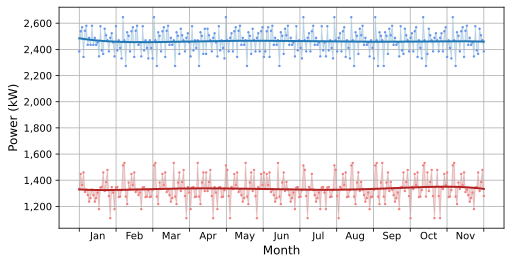

In [75]:
#-----------------------------------------------
upper = []
lower = []
if np.std(mm['MaxValue']) >= np.std(mm['MinValue']):
    for u,l in zip(mm["MaxValue"],mm["MinValue"]):
        if u >= np.mean(mm['MaxValue'])*cutoff_factor:
            upper.append(u)
            lower.append(l)
else:
    for u,l in zip(mm["MaxValue"],mm["MinValue"]):
        if l >= np.mean(mm['MinValue'])*cutoff_factor:
            upper.append(u)
            lower.append(l)
# -----------------------------------------------


time = np.linspace(0, len(upper), len(upper))   #an array for the x axis
tix = np.linspace(0, len(upper), number_of_months+1)   #an array for the tickmarks

plt.figure(figsize=(8, 4))

plt.plot(time, upper, '.', color = 'cornflowerblue', markersize = '3', label = 'upper value') #plotting markers for the upper and lower values
plt.plot(time, lower, '.', color = 'lightcoral', markersize = '3', label = 'lower value')


#this plots the lines of best fit
#----------------------------------------------------------------
upcoefs = np.polyfit(time, upper, deg = 5)
lowcoefs = np.polyfit(time, lower, deg = 5)

upline = np.polyval(upcoefs, time)
lowline = np.polyval(lowcoefs, time)

plt.plot(time, upline, color = 'tab:blue', linewidth = '2')
plt.plot(time, lowline, color = 'firebrick', linewidth = '2')
#-----------------------------------------------------------------


plt.fill_between(time, upper, upline,color = 'tab:blue', alpha = 0.2)
plt.fill_between(time, lower, lowline, color = 'firebrick', alpha = 0.2)

plt.xlabel('Month', size = 12)                                            #x label
plt.ylabel('Power (kW)', size = 12)                                       #y label
plt.xticks(ticks = tix, visible = False)                                  #hiding the x axis ticks
plt.gca().set_xticks(ticks = tix + len(upper)/number_of_months/2, minor=True)#, labels = month_titles)   #naming the x ticks and putting them in the middle
plt.gca().set_xticklabels(month_titles, minor=True)
plt.tick_params(axis = 'x', which = 'minor', size = 0)
plt.gca().yaxis.set_major_formatter(commas)                    #adding commas to the y axis values
plt.grid()                                                     #grid

plt.savefig('Max_Min_kW_For_The_Year.png')     #saves a figure into the same folder as this ipynb

n = len(time)
print(f'Days Accounted For: {n}')   #this is so you can see how many days are being plotted, useful if outliers were excluded


# kW max/min by the day of week

Days Accounted For: 288


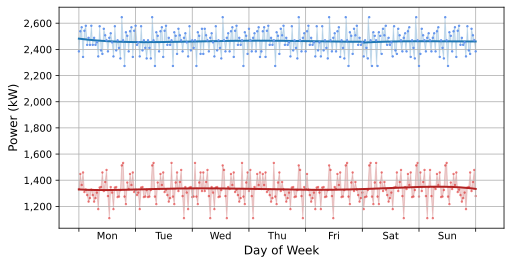

In [79]:
mm['dayofweek'] = pd.to_datetime(mm['Date']).dt.dayofweek
mm = mm.sort_values(['dayofweek', 'Date'])

#---------------------------------------
upper = []
lower = []
wknd = []
wkdy = []
if np.std(mm['MaxValue']) >= np.std(mm['MinValue']):
    for u, l, d in zip(mm['MaxValue'], mm['MinValue'], mm['dayofweek']):
        if d >= 5 or u >= np.mean(mm['MaxValue'])*cutoff_factor:
            upper.append(u)
            lower.append(l)
            if d >= 5:
                wknd.append(u)
            else:
                wkdy.append(u)
else:
    for u, l, d in zip(mm['MaxValue'], mm['MinValue'], mm['dayofweek']):
        if l >= np.mean(mm['MinValue'])*cutoff_factor:
            upper.append(u)
            lower.append(l)
            if d >= 5:
                wknd.append(u)
            else:
                wkdy.append(u)
#---------------------------------------

time = np.linspace(0, len(upper), len(upper))
wkdy_time = np.linspace(0, len(wkdy), len(wkdy))
wknd_time = np.linspace(0, len(wknd), len(wknd))

tix = np.linspace(0, len(upper), 8)

wknd_coefs = np.polyfit(wknd_time, wknd, deg = 3)
wkdy_coefs = np.polyfit(wkdy_time, wkdy, deg = 4)
lowcoefs = np.polyfit(time, lower, deg = 5)

wknd_mean = np.polyval(wknd_coefs, wknd_time)
wkdy_mean = np.polyval(wkdy_coefs, wkdy_time)
lmean = np.polyval(lowcoefs, time)

wknd_time = wknd_time + np.max(wkdy_time)

plt.figure(figsize=(8, 4))

plt.plot(wknd_time, wknd_mean, color = 'tab:blue', linewidth = '2')
plt.plot(wkdy_time, wkdy_mean, color = 'tab:blue', linewidth = '2')
plt.plot(time, lmean, color = 'firebrick', linewidth = '2')

plt.plot([wkdy_time[-1], wknd_time[0]], [wkdy_mean[-1], wknd_mean[0]], '--', color='tab:blue')

plt.fill_between(wkdy_time, upper[:len(wkdy)], wkdy_mean, color = 'tab:blue', alpha = 0.2)
plt.fill_between(wknd_time, upper[len(wkdy):], wknd_mean, color = 'tab:blue', alpha = 0.2)
plt.fill_between(time, lower, lmean, color = 'firebrick', alpha = 0.2)

plt.plot(time, upper, '.', color = 'cornflowerblue', markersize = '3', label = 'upper value') 
plt.plot(time, lower, '.', color = 'lightcoral', markersize = '3', label = 'lower value', zorder = 0)

plt.xticks(ticks = tix, labels = day_titles, visible = False)
plt.gca().set_xticks(ticks = tix + len(upper)/14, minor = True)
plt.gca().set_xticklabels(day_titles, minor=True)
plt.tick_params(axis = 'x', which = 'minor', size = 0)

plt.ylabel('Power (kW)', size = 12)
plt.xlabel('Day of Week', size = 12)
plt.gca().yaxis.set_major_formatter(commas)
plt.grid()

plt.savefig('Max_Min_kW_By_Day_of_Week.png')

print(f'Days Accounted For: {len(time)}')

# Monthly kW Usage by Time of Day

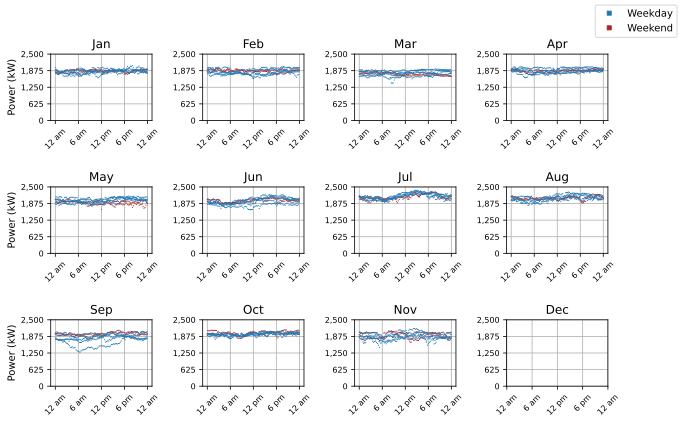

In [80]:
day_of_week = []
time = []
kW = []
month = []
for d, t, k, m in zip(dp['Day of Week'], dp['Time'], dp['kW'], dp['Month']):
    if d == 6 or d == 7:
        day_of_week.append(d)
        time.append(t)
        kW.append(k)
        month.append(m)

wknd = pd.DataFrame()
wknd['day_of_week'] = day_of_week
wknd['time'] = time
wknd['kW'] = kW
wknd['month'] = month


day_of_week = []
time = []
kW = []
month = []
for d, t, k, m in zip(dp['Day of Week'], dp['Time'], dp['kW'], dp['Month']):
    if d != 6 and d != 7:
        day_of_week.append(d)
        time.append(t)
        kW.append(k)
        month.append(m)

wkdy = pd.DataFrame()
wkdy['day_of_week'] = day_of_week
wkdy['time'] = time
wkdy['kW'] = kW
wkdy['month'] = month

wkdy = wkdy.sort_values(['month', 'time'])
wknd = wknd.sort_values(['month', 'time'])
#----------------------------------------------------------------------------

fig, axes = plt.subplots(nrows = 3, ncols = 4, figsize = (10, 6))   #creating 12 subplots
plt.subplots_adjust(wspace=0.5, hspace=1.0)                         #spacing out the subplots

for i, ax in enumerate(axes.flatten()):
    subset_wkdy = wkdy[wkdy['month'] == i + 1]    #separating the data frames into months
    subset_wknd = wknd[wknd['month'] == i + 1]      

    ax.plot(np.linspace(0, 24, len(subset_wknd)), (subset_wknd['kW']), ',', color = 'firebrick', label = 'weekend')
    ax.plot(np.linspace(0, 24, len(subset_wkdy)), (subset_wkdy['kW']), ',', color = 'tab:blue', label = 'weekday')     #plotting data


    ax.set_xticks(ticks = np.linspace(0, 24, 5))  #x axis goes from 0 to 24, with 5 tickmarks
    ax.set_xticklabels(Ip[::6],  rotation = 45)
    ax.set_yticks(ticks = np.linspace(0, np.ceil(np.max(dp['kW'])/100)*100 + 100, 5))   #y axis goes from 0 to the max(rounded up to the next hundred) with 5 tickmarks
    ax.set_title(set_month_titles[i])          #naming the subplots 
    ax.tick_params(labelsize = 8)          #making the font size for the axis smaller
    if i % 4 == 0:                         #check if it's the leftmost subplot in each row
        ax.set_ylabel('Power (kW)', size = 10)                #y-axis label for the leftmost subplot
    ax.grid()                              #grid
    ax.yaxis.set_major_formatter(commas)   #add commas to the y axis
    
    
legend_handles = [plt.Line2D([], [], marker='s', markersize=4, linestyle='None', label='Weekday', color = 'tab:blue'),
                  plt.Line2D([], [], marker='s', markersize=4, linestyle='None', label='Weekend', color = 'firebrick')]

fig.legend(handles=legend_handles)

plt.savefig('Monthly_kW_by_Time_of_Day.png')     #saves a figure into the same folder as this ipynb


# Monthly kW Usage by Day of Week

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


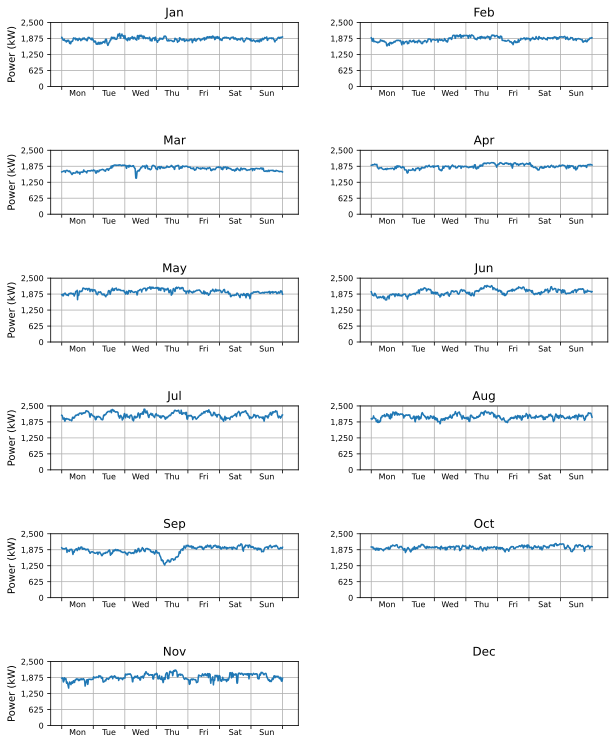

In [10]:
dp = dp.sort_values(['Month', 'Day of Week'])   #sorting the entire dataframe by month and then day of the week
dp['x'] = np.arange(len(dp))                    #creating a new column that assigns a number to each row in this new order

fig, axes = plt.subplots(nrows = 6, ncols = 2, figsize=(10, 12))  #creating 12 subplots
plt.subplots_adjust(top = .925, wspace=0.25, hspace=1)            #spacing out the subplots



for i, ax, in enumerate(axes.flatten()):
    subset = dp[dp['Month'] == i + 1]        #splitting the data into 12 subsets
    ax.plot(subset['x'], subset['kW'], '-', color = 'tab:blue')   #plotting each subset into it's respective subplot


    tix = np.linspace(np.min(subset['x']), np.max(subset['x']), 8)
    middle_tix = tix + len(subset['x'])/14

    ax.set_yticks(ticks = np.linspace(0, np.ceil(np.max(dp['kW'])/100)*100+100, 5))  #y axis goes from 0 to the max(rounded up to the next hundred) with 5 tickmarks
    ax.set_xticks(ticks = tix)
    ax.set_xticklabels(day_titles, visible = False)
    ax.set_xticks(ticks = middle_tix, minor = True)
    ax.set_xticklabels(day_titles, size = 8, minor=True)
    ax.tick_params(axis = 'x', which = 'minor', size = 0)
    ax.tick_params(labelsize = 8)

    ax.set_title(set_month_titles[i])             #naming subplots
    if i % 2 == 0:                            #Check if it's the leftmost subplot in each row
        ax.set_ylabel('Power (kW)', size = 10)                   #y-axis label for the leftmost subplot
    ax.yaxis.set_major_formatter(commas)      #add commas to the y axis
    ax.grid() 
    


# plt.savefig('Monthly_kW_by_Day_of_Week.png')   #saves a figure into the same folder as this ipynb


# Histogram of peaks by time of day

days accounted for: 320


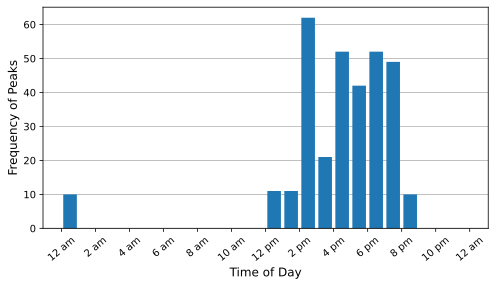

In [11]:
#if you want to exclude days that have an upper kW output less than the mean * cutoff_factor, then run this section of code
#-----------------------------------------------
MaxTime = []
for u,t in zip(mm["MaxValue"],mm["MaxTime"]):
    if u >= np.mean(mm['MaxValue'])*cutoff_factor:
        MaxTime.append(t)
#-----------------------------------------------

hours = [time.hour for time in MaxTime]
tix = np.linspace(0, 23, 13)

plt.figure(figsize=(8, 4))
plt.hist(hours, bins = 24, range = (0, 23), rwidth = 0.8, color = 'tab:blue')
plt.gca().set_axisbelow(True)
plt.grid(axis = 'y')

plt.xticks(ticks = tix, labels = Ip[::2], rotation = 40, size = 10)
plt.xlabel('Time of Day', size = 12)
plt.ylabel('Frequency of Peaks', size = 12)

plt.savefig('Peak_Frequency_by_Time_of_Day.png')
print(f'days accounted for: {len(MaxTime)}')

# Histogram of peaks by kW Values

days accounted for: 320


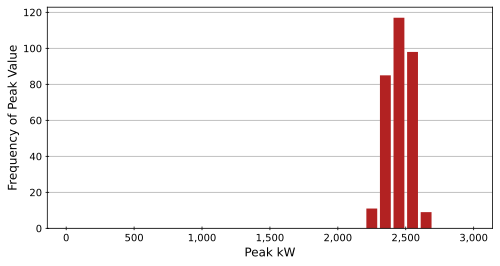

In [12]:
#if you want to exclude days that have an upper kW output less than the mean * cutoff_factor, then run this section of code
#-----------------------------------------------
MaxValue = []
for u in mm["MaxValue"]:
    if u >= np.mean(mm['MaxValue'])*cutoff_factor:
        MaxValue.append(u)
# -----------------------------------------------

high = np.ceil(np.max(MaxValue)/1000)*1000

plt.figure(figsize=(8, 4))
plt.hist(MaxValue, bins = int(high/100), rwidth = 0.8, range = (0, high), color = 'firebrick')

plt.gca().xaxis.set_major_formatter(commas)
plt.gca().set_axisbelow(True)
plt.grid(axis = 'y')
plt.tick_params(axis = 'both', direction = 'inout')
plt.ylabel('Frequency of Peak Value', size = 12)
plt.xlabel('Peak kW', size = 12)

plt.savefig('Peak_Frequency_by_Peak_Value.png')

print(f'days accounted for: {len(MaxValue)}')

# Monthly kW Peak Profile

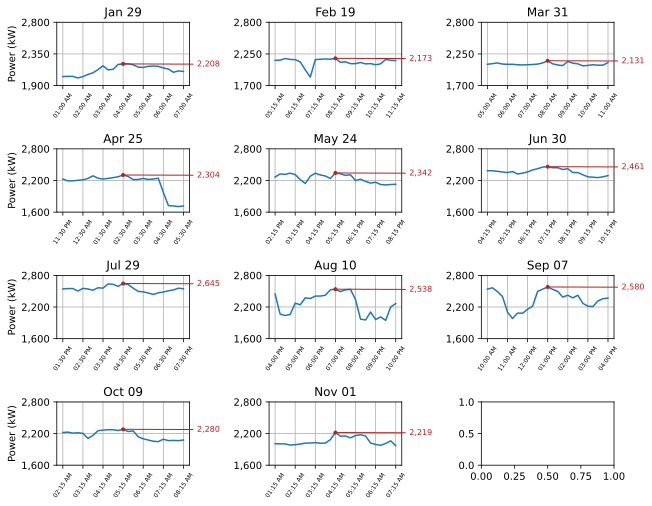

In [13]:
rng = 60/time_interval*3 #amount of datapoints for 3 hours before/after the max

fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize=(10, 8))  #creating 12 subplots
plt.subplots_adjust(wspace=0.6, hspace=1.0) 

lower = []
n = 0
for i, ax in zip(which_months, axes.flatten()):
    
    idxmax = df.loc[df['Timestamp'].dt.month == i,  power_title].idxmax()
    subset = df.loc[idxmax-rng:idxmax+rng]
    high = subset[power_title].max()
    low = subset[power_title].min()
    lower.append(low) 

    tix = subset['Timestamp'].dt.strftime('%I:%M %p')
    title = subset['Timestamp'].dt.strftime('%b %d')
    
    ax.plot(tix, subset[power_title])
    ax.plot(rng, high, '.', color = 'firebrick')
    ax.annotate(f'{int(high):,}', xy=(rng, high), xytext=(74, -2.5), textcoords='offset points', arrowprops=dict(arrowstyle='-', color = 'firebrick'), color = 'firebrick', size = 8)

    ax.set_xticks(tix[::int(60/time_interval)])
    ax.set_yticks(ticks = np.linspace(np.floor(np.min(lower)/100-1)*100, np.ceil(np.max(df[power_title])/100+1)*100, 3))   #y axis goes from 0 to the max(rounded up to the next hundred) with 5 tickmarks
    ax.set_title(title.max())          #naming the subplots 
    ax.tick_params(axis = 'x', labelsize = 6, rotation = 55)          #making the font size for the axis smaller

    if (n) % 3 == 0:                         #check if it's the leftmost subplot in each row
        ax.set_ylabel('Power (kW)', size = 10)                #y-axis label for the leftmost subplot
    ax.grid()                              #grid
    ax.yaxis.set_major_formatter(commas)   #add commas to the y axis
    n += 1
    
plt.savefig('Monthly_Peak_Profile.png')

# Grid Plot

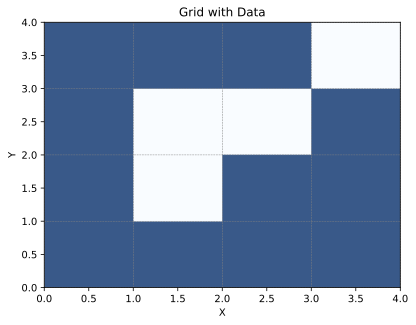

In [14]:
def plot_filled_grid(data):
    # Get the size of the data array
    grid_size_x, grid_size_y = data.shape

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Generate grid data
    x = np.arange(grid_size_x + 1)
    y = np.arange(grid_size_y + 1)

    # Plot vertical grid lines
    for i in range(grid_size_x + 1):
        ax.axvline(x=i, color='gray', linestyle='--', lw=0.5)

    # Plot horizontal grid lines
    for i in range(grid_size_y + 1):
        ax.axhline(y=i, color='gray', linestyle='--', lw=0.5)

    # Plot the filled squares using imshow
    ax.imshow(data, cmap='Blues', origin='lower', alpha=0.8,
              extent=[0, grid_size_x, 0, grid_size_y], aspect='auto')

    # Set the axis limits
    ax.set_xlim(0, grid_size_x)
    ax.set_ylim(0, grid_size_y)

    # Set axis labels (optional)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    # Set title (optional)
    ax.set_title(f'Grid with Data')

    # Show the grid
    plt.show()

# Example data array representing a 5x5 grid with some filled cells
data_array = np.array([
    [1, 1, 1, 1],
    [1, 0, 1, 1],
    [1, 0, 0, 1],
    [1, 1, 1, 0],
])

plot_filled_grid(data_array)


# How far this has come

### These are the very first graphs I came up with working on this project:

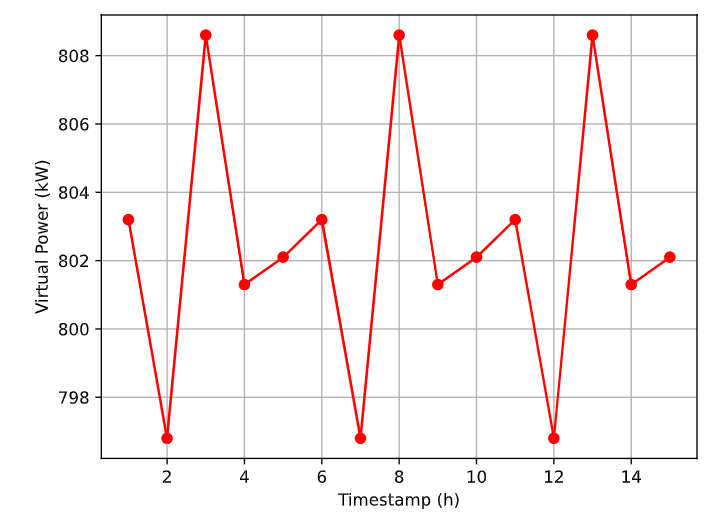
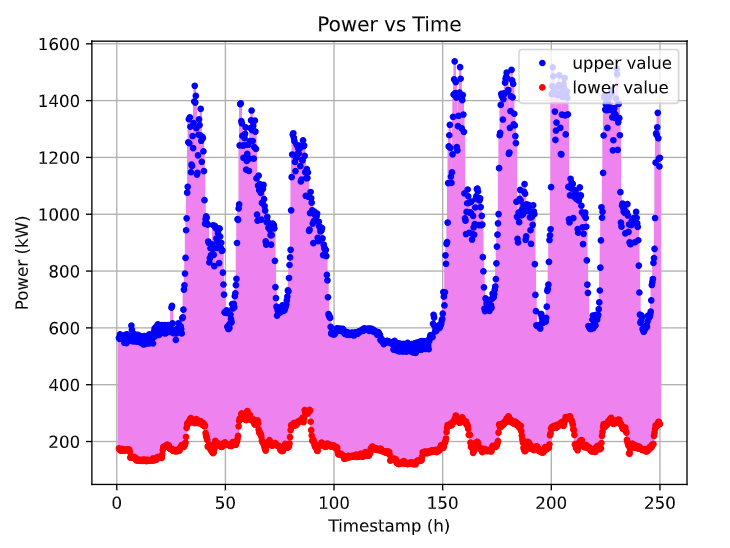
